In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Storm_Figs_V6.2.1/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri, Subset):
    Data_DF = Open_File(Diri+Model+'_Data_'+Subset+'_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_'+Subset+'_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
# Edit Time Format
    Time, Begin_Time, Compl_Time, Trop_Peak_Time, Peak_Time, Birth_Time = [], [], [], [], [], []
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Trop_Peak_Time.append(Datetime(ET_DF["Trop Peak Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
        Birth_Time.append(Datetime(ET_DF["Genesis Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Trop Peak Time"] = Trop_Peak_Time
    ET_DF["Peak Time"] = Peak_Time
    ET_DF["Genesis Time"] = Birth_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri, "SubsetA")
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri, "SubsetA")
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri, "SubsetA")

In [7]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [8]:
# Define Cyclone Type, Set Shape and Colour Code
SLP_Colours = ['darkviolet', 'mediumvioletred', 'magenta', 'red', 'orangered', \
'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'limegreen', 'deepskyblue', 'cyan']
SLP_Bounds = Create_Bins(900,1010,10)
def Cyclone_Type(DF, ET_DF, Storm_List):
# Cyclone Type and Shape Code
    Plot_Shape = []
    for i in range(len(DF["Storm Phase"])):
        if DF["Storm Phase"][i] == "Tropical":
            Plot_Shape.append('o')
        elif DF["Storm Phase"][i] == "Transition":
            Plot_Shape.append('s')
        elif DF["Storm Phase"][i] == "Extratropical":
            Plot_Shape.append('^')
        else:
            print (DF["Storm Type"][i])
    DF["Plot Shape"] = Plot_Shape
#   
# SLP Colour Code
    Plot_Colour = []
    for i in range(len(DF["SLP(hPa)"])):
        Bin = numpy.digitize(DF["SLP(hPa)"][i], bins=SLP_Bounds, right=True)
        Plot_Colour.append(SLP_Colours[Bin])
    DF["Plot Colour"] = Plot_Colour
    return (DF)

In [9]:
Control_Data_Plot = Cyclone_Type(Control_Data, Control_ET, Control_Codes["New Code"])
RCP45_Data_Plot = Cyclone_Type(RCP45_Data, RCP45_ET, RCP45_Codes["New Code"])
RCP85_Data_Plot = Cyclone_Type(RCP85_Data, RCP85_ET, RCP85_Codes["New Code"])

In [10]:
# Create Legend
def Plot_TC_Legend(Loc):
    pyplot.scatter([-728], [-728], c='cyan', marker='o', linewidths=0.8, edgecolors='black', label='Tropical')
    pyplot.scatter([-728], [-728], c='cyan', marker='s', linewidths=0.8, edgecolors='black', label='Transition')
    pyplot.scatter([-728], [-728], c='cyan', marker='^', linewidths=0.8, edgecolors='black', label='Extratropical')
    pyplot.legend(loc=Loc, fontsize=12)

In [11]:
# Plot Cyclone Phase Diagram
def Plot_Cyclone_Info(Storm_Code, DF, ET_DF, Bounds, Colours, Loc, Trans, Model, Fig_Label, Savefig):
    DF_Storm = DF[DF['Code'] == Storm_Code].reset_index()
    ET_Storm = ET_DF[ET_DF["Code"] == Storm_Code].reset_index()
    VLT = numpy.array(DF_Storm['VLT'])[1:]
    VUT = numpy.array(DF_Storm['VUT'])[1:]
    B = numpy.array(DF_Storm['B'])[1:]
    Time = list(DF_Storm['Time(Z)'])
    SLP = numpy.array(DF_Storm['SLP(hPa)'])
    Lon = numpy.array(DF_Storm['Lon'])
    Lat = numpy.array(DF_Storm['Lat'])
    Plot_Colour = list(DF_Storm['Plot Colour'])
    Plot_Shape = list(DF_Storm['Plot Shape'])
    Plot_Colour_1 = list(DF_Storm['Plot Colour'])[1:]
    Plot_Shape_1 = list(DF_Storm['Plot Shape'])[1:]
#
# Plotting VUT VLT
    Fig = pyplot.figure(figsize=(16,16))
    Axis = Fig.add_subplot(2,2,1)
    x_Axis = Create_Bins(-500,500,100)
    y_Axis = Create_Bins(-30,120,10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-30,120)
    pyplot.fill_between([0,500], 15, 120, color='violet', alpha=0.2)
    pyplot.fill_between([-500,0], 15, 120, color='mediumblue', alpha=0.2)
    pyplot.fill_between([0,500], -30, 15, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], -30, 15, color='darkgrey', alpha=0.2)
    pyplot.plot([-500,500], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-30,120], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    Axis.plot(VLT, B, c='black', linewidth=0.5, alpha=0.5)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], B[k], c=Plot_Colour_1[k], marker=Plot_Shape_1[k], linewidths=0.5, edgecolors='black', s=78)
    if Trans == True:
        Trans_Type = ET_Storm["Trans Type"][0]
        if Trans_Type > -1:
            Start_Time = ET_Storm["ET Begin Time"][0]
            Start_DF = DF_Storm[DF_Storm["Time(Z)"] == Start_Time]
            pyplot.scatter(Start_DF["VLT"], Start_DF["B"], marker='s', linewidths=4.8, \
            facecolors='none', edgecolors='black', s=178)
            if Trans_Type > 0:
                End_Time = ET_Storm["ET Complete Time"][0]
                End_DF = DF_Storm[DF_Storm["Time(Z)"] == End_Time]
                pyplot.scatter(End_DF["VLT"], End_DF["B"]+0.5, marker='^', linewidths=4.2, \
                facecolors='none', edgecolors='black', s=208)
    Title = str(Model + ': ' + DF_Storm['Code'][0] + ' ' + DF_Storm['Name'][0])
    Axis.set_title(Title, fontsize=18)
    Plot_TC_Legend(Loc)
    if Fig_Label == True:
        Letter_Label(Axis, Storm_Name, 0)
#
# Plotting VUT VLT
    Axis = Fig.add_subplot(2,2,2)
    x_Axis = Create_Bins(-500,500,100)
    y_Axis = Create_Bins(-500,500,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-500,500)
    pyplot.fill_between([0,500], 500, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], 500, color='lightskyblue', alpha=0.2)
    pyplot.fill_between([0,500], -500, color='orangered', alpha=0.2)
    pyplot.fill_between([-500,0], -500, color='mediumblue', alpha=0.2)
    pyplot.plot([-500,500], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-500,500], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    Axis.plot(VLT, VUT, c='black', linewidth=0.5, alpha=0.5)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], VUT[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.5, edgecolors='black', s=78)
    if Trans == True:
        Trans_Type = ET_Storm["Trans Type"][0]
        if Trans_Type > -1:
            Start_Time = ET_Storm["ET Begin Time"][0]
            Start_DF = DF_Storm[DF_Storm["Time(Z)"] == Start_Time]
            pyplot.scatter(Start_DF["VLT"], Start_DF["VUT"], marker='s', linewidths=4.8, \
            facecolors='none', edgecolors='black', s=178)
            if Trans_Type > 0:
                End_Time = ET_Storm["ET Complete Time"][0]
                End_DF = DF_Storm[DF_Storm["Time(Z)"] == End_Time]
                pyplot.scatter(End_DF["VLT"], End_DF["VUT"]+0.5, marker='^', linewidths=4.2, \
                facecolors='none', edgecolors='black', s=208)
    Axis.set_title(Title, fontsize=18)
    if Fig_Label == True:
        Letter_Label(Axis, Storm_Name, 1)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.6, -0.095, 1, 0.025], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', spacing='proportional', \
    cax=Cax, label='SLP(hPa)', shrink=0.7)
#
# Plotting Storm Track
    Axis = Fig.add_subplot(2,2,3, projection=ccrs.PlateCarree())
    Axis.coastlines(linewidth=0.5)
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    Axis.plot(Lon, Lat, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Lon)):
        pyplot.scatter(Lon[k], Lat[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.5, edgecolors='black', s=78)
    if Trans == True:
        Trans_Type = ET_Storm["Trans Type"][0]
        if Trans_Type > -1:
            pyplot.scatter(ET_Storm["ET Begin Lon"][0], ET_Storm["ET Begin Lat"][0], marker='s', \
            linewidths=4.8, facecolors='none', edgecolors='black', s=178)
            if Trans_Type > 0:
                pyplot.scatter(ET_Storm["ET Complete Lon"][0], ET_Storm["ET Complete Lat"][0]+0.1, marker='^', \
                linewidths=4.2, facecolors='none', edgecolors='black', s=208)
    x_Min = (int(round((numpy.min(Lon)+1.5) / 5)) - 1) * 5
    x_Max = (int(round((numpy.max(Lon)-1.5) / 5)) + 1) * 5
    y_Min = (int(round((numpy.min(Lat)+1.5) / 5)) - 1) * 5
    y_Max = (int(round((numpy.max(Lat)-1.5) / 5)) + 1) * 5
    x_Axis = Create_Bins(x_Min,x_Max,5)
    y_Axis = Create_Bins(y_Min,y_Max,5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='silver', linestyle='-')
    Gridline.xlocator = mticker.FixedLocator(x_Axis)
    Gridline.ylocator = mticker.FixedLocator(y_Axis)
#
# Plotting Storm SLP
    Axis = Fig.add_subplot(2,2,4)
    Axis.plot(Time, SLP, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Time)):
        Axis.scatter(Time[k], SLP[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.8, edgecolors='black', s=78)
    if Trans == True:
        Trans_Type = ET_Storm["Trans Type"][0]
        if Trans_Type > -1:
            pyplot.scatter(ET_Storm["ET Begin Time"][0], ET_Storm["ET Begin SLP"][0], marker='s', \
            linewidths=4.8, facecolors='none', edgecolors='black', s=178)
            if Trans_Type > 0:
                pyplot.scatter(ET_Storm["ET Complete Time"][0], ET_Storm["ET Complete SLP"][0]+0.2, marker='^', \
                linewidths=4.2, facecolors='none', edgecolors='black', s=208)
    pyplot.xlabel('Time (Z)', fontsize=12)
    pyplot.ylabel('Sea Level Pressure (SLP)', fontsize=12)
    x_Min = Time[0] + datetime.timedelta(hours=-6)
    x_Max = Time[len(Time)-1] + datetime.timedelta(hours=6)
    x_Start = datetime.date(x_Min.year,x_Min.month,x_Min.day) + datetime.timedelta(1)
    x_End = datetime.date(x_Max.year,x_Max.month,x_Max.day) + datetime.timedelta(1)
    if len(Time) < 40:
        x_Axis = pandas.date_range(x_Start,x_End,freq='D')
    elif len(Time) < 80:
        x_Axis = pandas.date_range(x_Start,x_End,freq='2D')
    else:
        x_Axis = pandas.date_range(x_Start,x_End,freq='3D')
    y_Min = (int(round(numpy.min(SLP) / 5)) - 1) * 5
    y_Max = (int(round(numpy.max(SLP) / 5)) + 1) * 5
    if y_Max - y_Min < 60:
        y_Axis = Create_Bins(y_Min,y_Max,5)
    else:
        if y_Min % 10 == 0:
            y_Axis = Create_Bins(y_Min,y_Max,10)
        else:
            y_Axis = Create_Bins(y_Min-5,y_Max+5,5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#
# Save Fig
    if Savefig == True:
        Figname = str('Selected_' + DF_Storm['Code'][0] + '_' + DF_Storm['Name'][0] + '.png')
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [12]:
# Plot Some Cyclone Tracks, SLP and Phase Plots

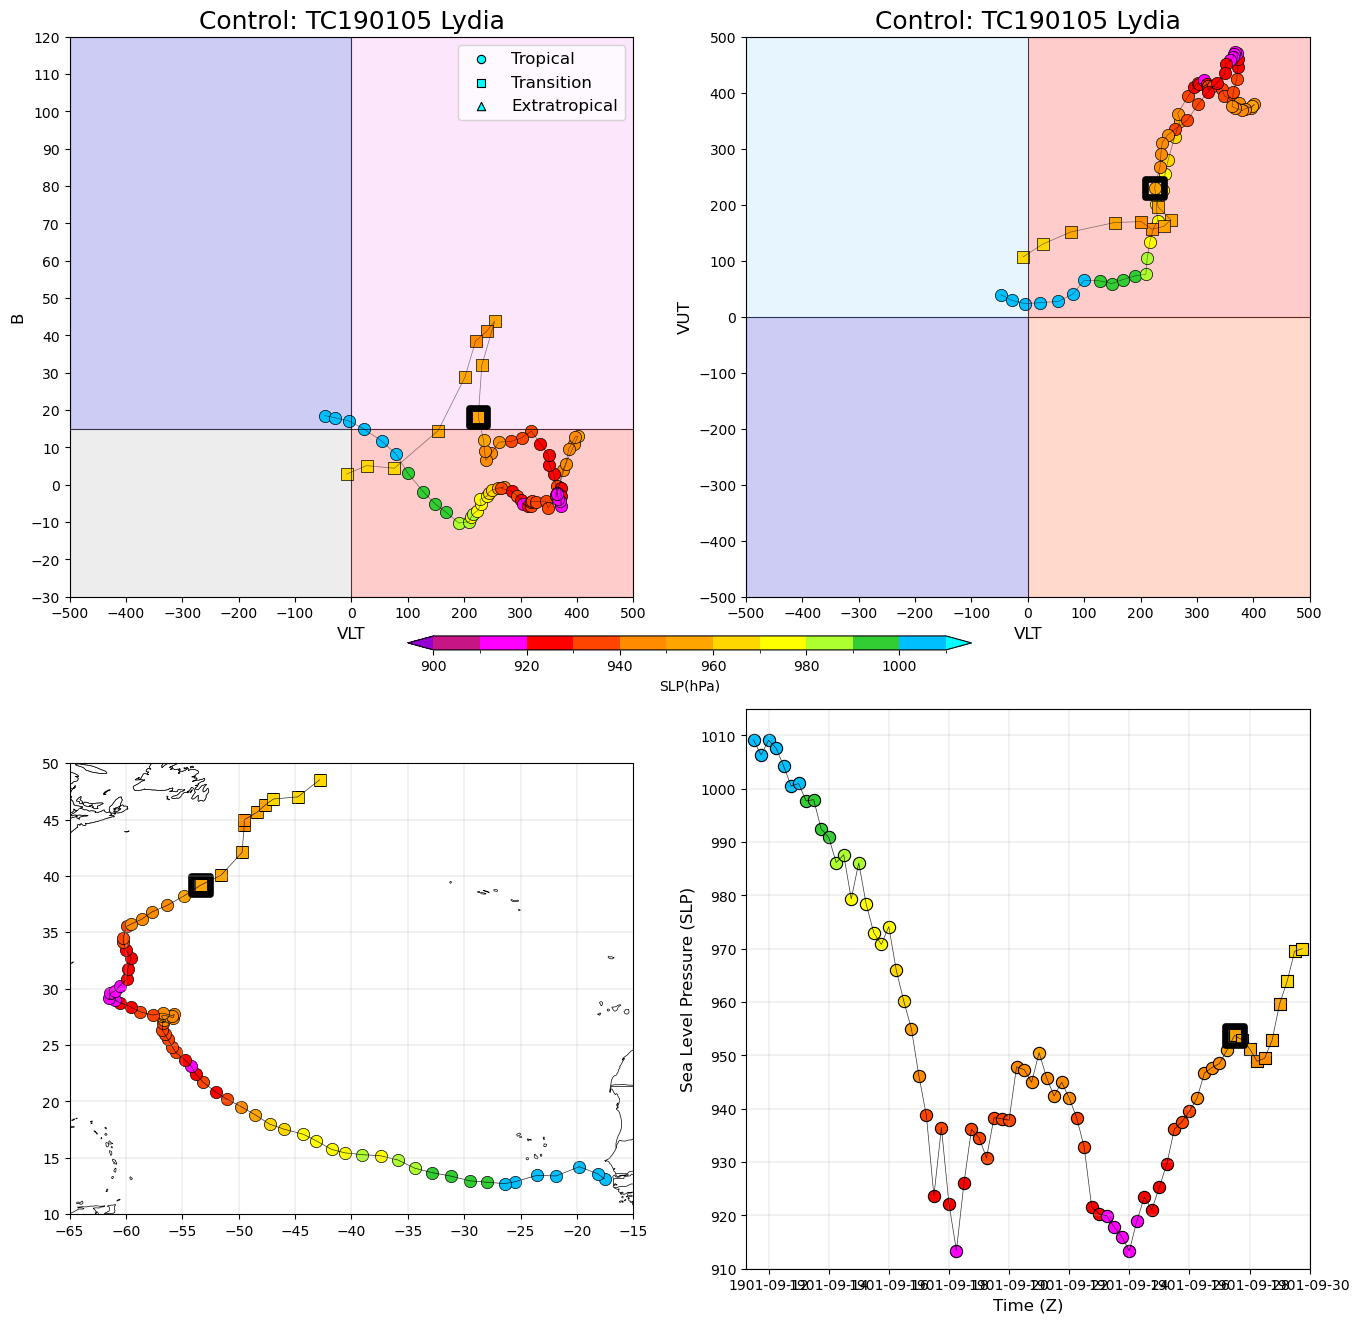

In [13]:
Storm_Code = 'TC190105'
DF, ET_DF = Control_Data, Control_ET
Model = "Control"
Bounds, Colours = SLP_Bounds, SLP_Colours
Loc = 1
Trans = True
Fig_Label = False
Savefig = False
Plot_Cyclone_Info(Storm_Code, DF, ET_DF, Bounds, Colours, Loc, Trans, Model, Fig_Label, Savefig)

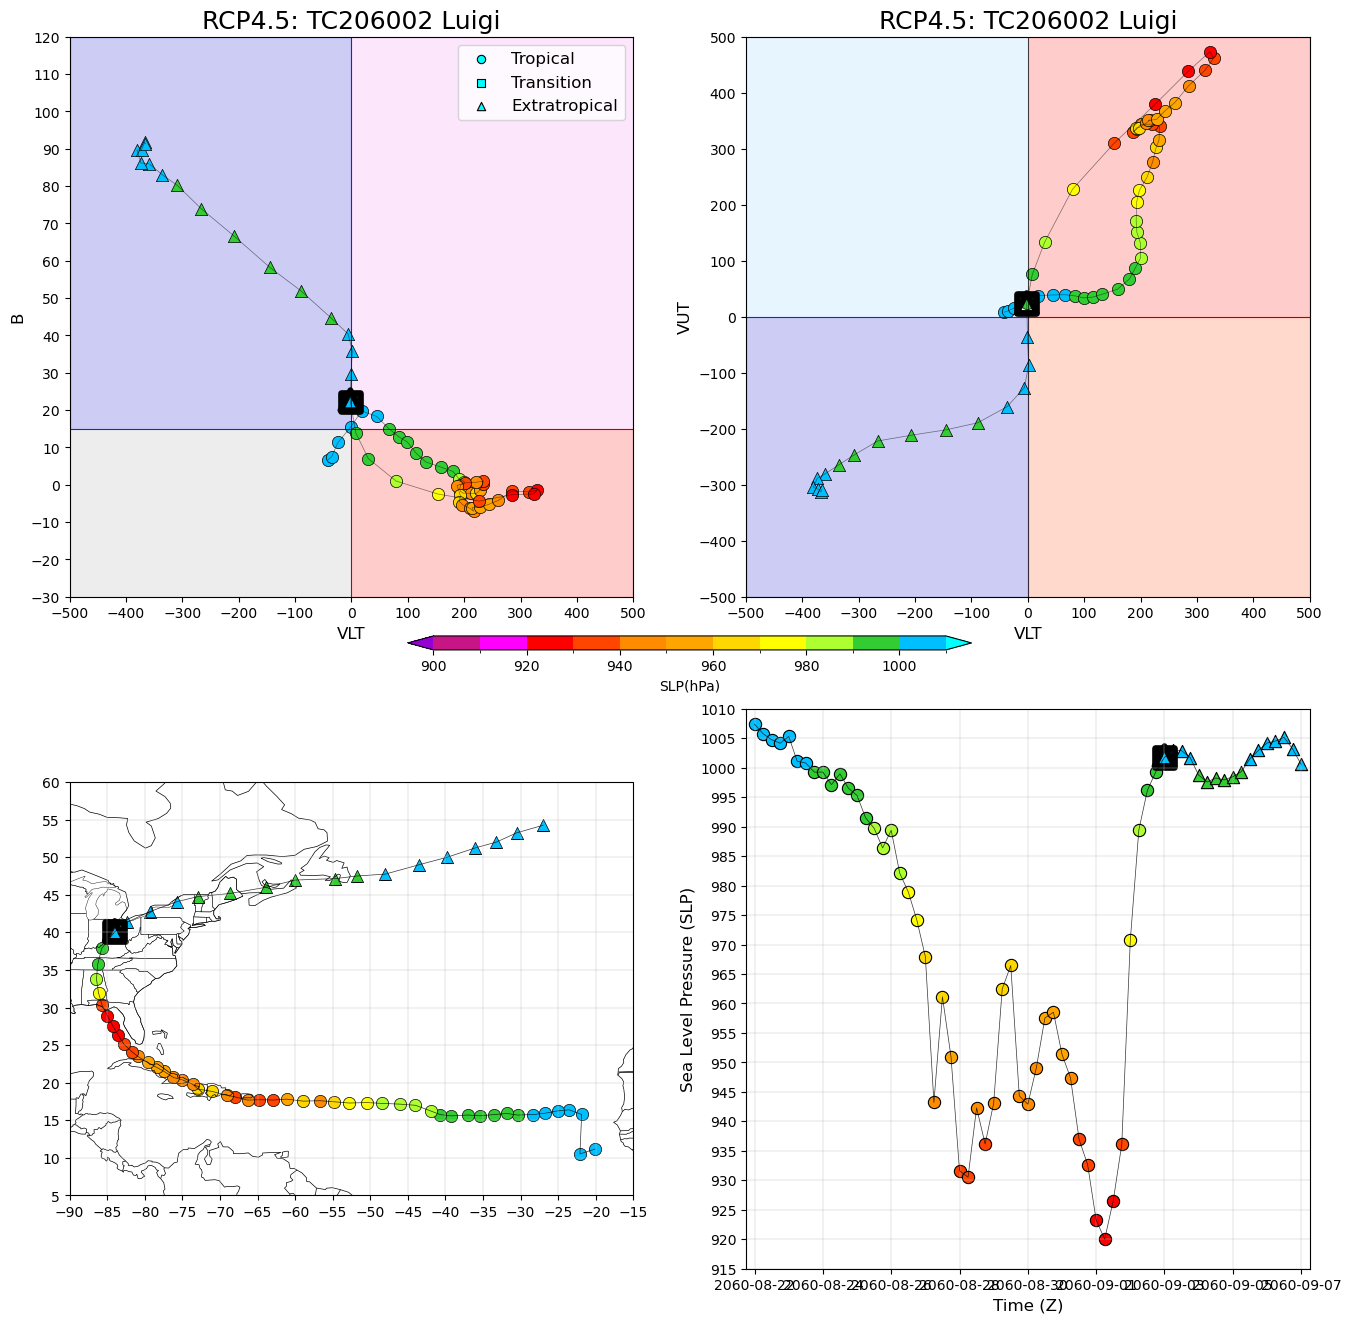

In [14]:
Storm_Code = 'TC206002'
DF, ET_DF = RCP45_Data, RCP45_ET
Model = "RCP4.5"
Bounds, Colours = SLP_Bounds, SLP_Colours
Loc = 1
Trans = True
Fig_Label = False
Savefig = False
Plot_Cyclone_Info(Storm_Code, DF, ET_DF, Bounds, Colours, Loc, Trans, Model, Fig_Label, Savefig)

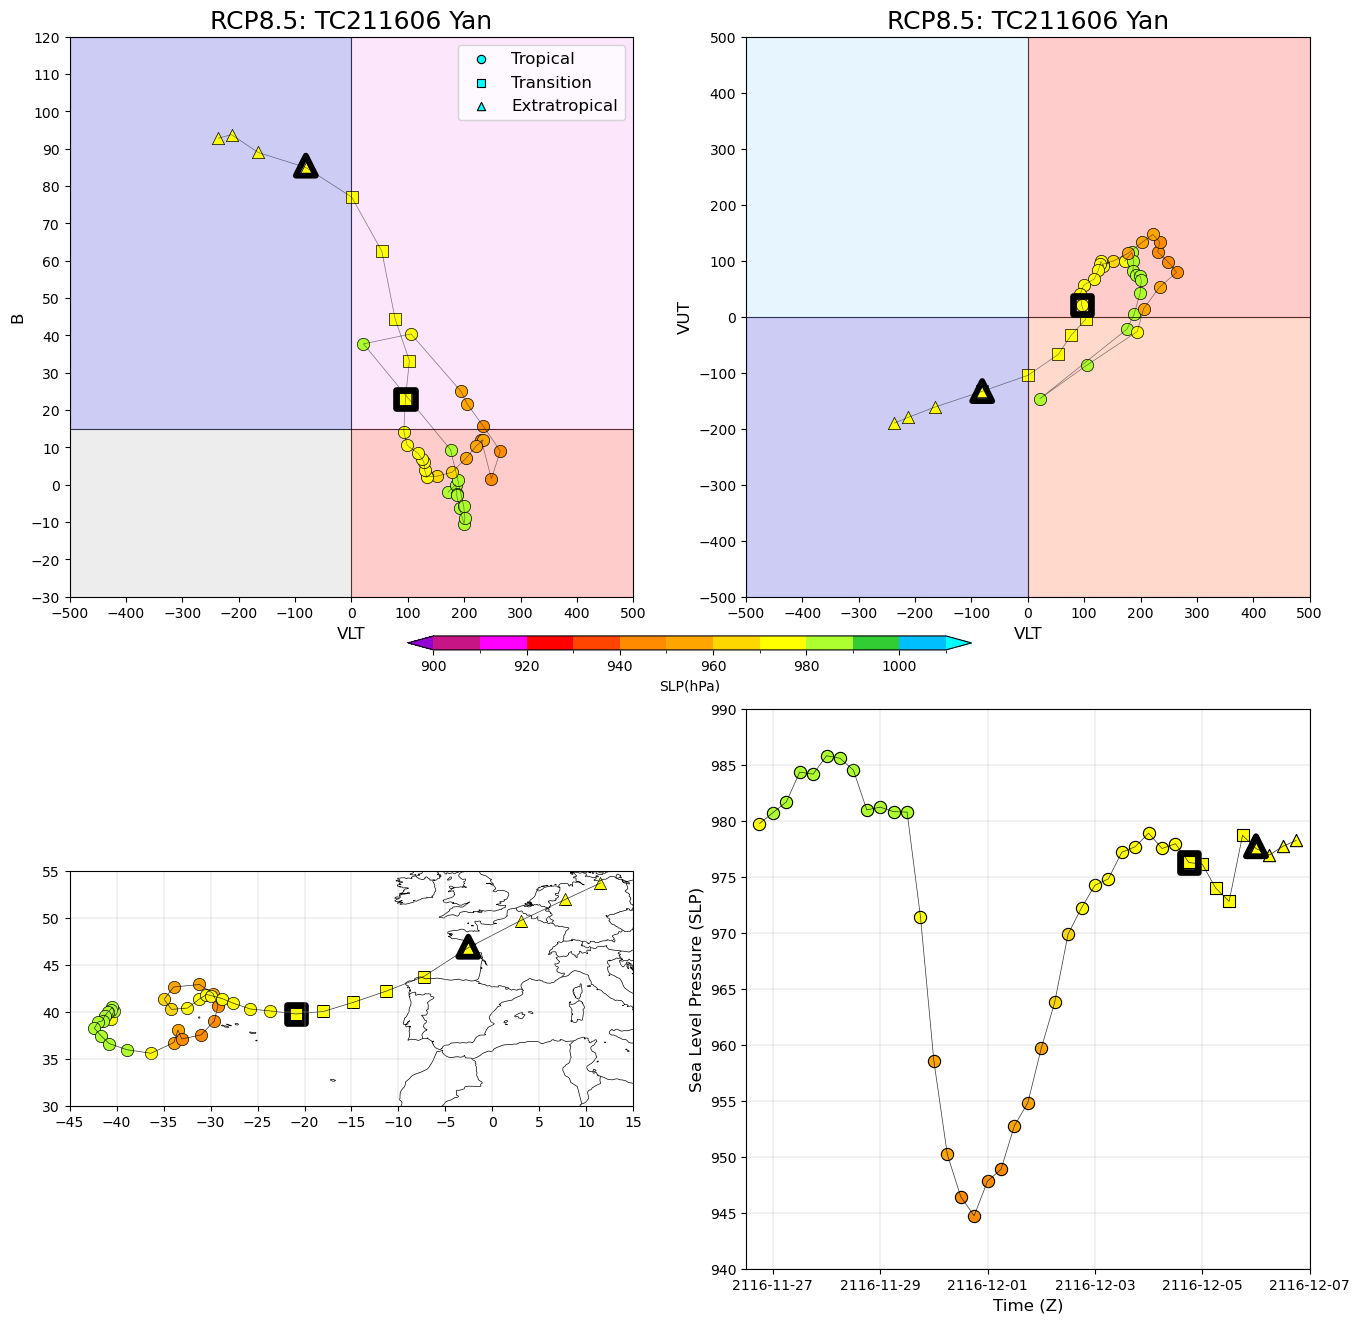

In [22]:
Storm_Code = 'TC211606'
DF, ET_DF = RCP85_Data, RCP85_ET
Model = "RCP8.5"
Bounds, Colours = SLP_Bounds, SLP_Colours
Loc = 1
Trans = True
Fig_Label = False
Savefig = False
Plot_Cyclone_Info(Storm_Code, DF, ET_DF, Bounds, Colours, Loc, Trans, Model, Fig_Label, Savefig)

In [16]:
# Input Code
#for i in range(len(Control_ET)):
#    Storm_Code = Control_ET["Code"][i]
#    if i >= 300 and i < 320:
#        Plot_Cyclone_Info(Storm_Code, Control_Data, Control_ET, SLP_Bounds, SLP_Colours, 1, True, "Control", False, False)

In [17]:
# Input Code
#for i in range(len(RCP45_ET)):
#    Storm_Code = RCP45_ET["Code"][i]
#    if i >= 200 and i < 220:
#        Plot_Cyclone_Info(Storm_Code, RCP45_Data, RCP45_ET, SLP_Bounds, SLP_Colours, 1, True, "RCP4.5", False, False)

In [18]:
# Input Code
#for i in range(len(RCP85_ET)):
#    Storm_Code = RCP85_ET["Code"][i]
#    if i >= 180 and i < 200:
#        Plot_Cyclone_Info(Storm_Code, RCP85_Data, RCP85_ET, SLP_Bounds, SLP_Colours, 1, True, "RCP8.5", False, False)

In [19]:
Control_ET[Control_ET["ET Begin Lat"] < 20]

,Code,Name,ABC,Trans Type,ET Begin Time,ET Complete Time,Peak Time,Trop Peak Time,Genesis Time,Peak SLP,...,Trop Peak Lat,ET Begin SLP,ET Begin Lon,ET Begin Lat,ET Complete SLP,ET Complete Lon,ET Complete Lat,Genesis SLP,Genesis Lon,Genesis Lat
176,TC192504,Frederick,A,0,1925-08-16 18:00:00,NaT,1925-08-22 00:00:00,1925-08-16 12:00:00,1925-08-12 12:00:00,979.13,...,17.91,1003.46,-60.35,18.01,NaN,NaN,NaN,1012.57,-43.67,11.36
367,TC195107,Aidan,B,1,1951-11-18 06:00:00,1951-11-19 12:00:00,1951-11-17 18:00:00,1951-11-17 18:00:00,1951-11-12 12:00:00,985.62,...,17.74,992.38,-79.10,19.45,998.14,-71.98,25.14,1002.91,-78.18,7.94
375,TC195210,Manuel,B,1,1952-11-11 12:00:00,1952-11-17 06:00:00,1952-11-11 06:00:00,1952-11-11 06:00:00,1952-11-07 06:00:00,968.65,...,16.70,978.04,-71.78,17.50,1004.78,-39.25,24.00,1004.70,-83.04,13.55
423,TC195808,Candy,B,1,1958-10-16 00:00:00,1958-10-18 12:00:00,1958-10-14 06:00:00,1958-10-14 06:00:00,1958-10-06 18:00:00,985.34,...,13.95,1006.12,-92.46,18.03,1007.86,-87.00,24.34,1004.79,-81.61,16.40
450,TC196309,Peach,C,0,1963-08-18 00:00:00,NaT,1963-08-13 18:00:00,1963-08-13 18:00:00,1963-08-12 00:00:00,993.89,...,13.75,1007.67,-95.96,18.74,NaN,NaN,NaN,1006.70,-64.57,12.70
552,TC197707,Audrey,C,0,1977-10-09 00:00:00,NaT,1977-10-11 12:00:00,1977-10-07 00:00:00,1977-10-05 12:00:00,998.62,...,13.45,1009.06,-84.80,12.13,NaN,NaN,NaN,1005.95,-81.15,13.52


In [20]:
RCP45_ET[RCP45_ET["Code"] == "TC202006"]

,Code,Name,ABC,Trans Type,ET Begin Time,ET Complete Time,Peak Time,Trop Peak Time,Genesis Time,Peak SLP,...,Trop Peak Lat,ET Begin SLP,ET Begin Lon,ET Begin Lat,ET Complete SLP,ET Complete Lon,ET Complete Lat,Genesis SLP,Genesis Lon,Genesis Lat
104,TC202006,Grace,A,1,2020-08-19 18:00:00,2020-08-20 06:00:00,2020-08-18 18:00:00,2020-08-18 18:00:00,2020-08-10 12:00:00,947.9,...,36.12,988.26,-72.59,43.04,998.72,-67.32,47.37,1009.93,-32.43,17.0


In [21]:
RCP85_ET[RCP85_ET["ET Begin Lat"] < 20]

,Code,Name,ABC,Trans Type,ET Begin Time,ET Complete Time,Peak Time,Trop Peak Time,Genesis Time,Peak SLP,...,Trop Peak Lat,ET Begin SLP,ET Begin Lon,ET Begin Lat,ET Complete SLP,ET Complete Lon,ET Complete Lat,Genesis SLP,Genesis Lon,Genesis Lat
118,TC212806,Dorcas,A,0,2128-10-19 12:00:00,NaT,2128-10-25 00:00:00,2128-10-19 00:00:00,2128-10-12 00:00:00,956.61,...,18.10,985.79,-81.64,18.65,NaN,NaN,NaN,1008.87,-82.85,16.79
273,TC216002,Derrick,B,0,2160-08-25 00:00:00,NaT,2160-08-27 18:00:00,2160-08-24 18:00:00,2160-08-17 18:00:00,869.71,...,16.82,909.20,-66.94,16.82,NaN,NaN,NaN,1005.36,-19.58,12.31
293,TC216304,Alice,C,2,2163-08-29 18:00:00,2163-08-30 06:00:00,2163-08-27 18:00:00,2163-08-27 18:00:00,2163-08-26 00:00:00,999.96,...,9.97,1007.95,-34.53,18.30,1012.04,-36.66,19.85,1006.95,-16.28,11.32
